# Notebook Introduction
This notebook is meant to follow up on the previous exploratory notebook done by shaul on some of our basic hypthesis regarding the quality of labels and labelers.<br>
So far, we have found that:<br>
- There is a significant difference between random and non-random dataset labels, albiet a lot of noise
- Duration of task does not correlate neither with labels nor with random/non-random separation nor even length of sentences
- high label varience (high disagreement) could be explainedby lazy labeling by one of the labelers 

in this notebook I'll try to answer on more questions:<br>
- 1. How can we identify suspicous labelers?<br>
    - higher mean for random pairs than for non-random
    - very low label varience
- 2. How does removing suspiocous labelers affect:<br>
    - correlation between time and length
    - amount (and randomness) of high disagreement pairs<br>
- 3. can we identify a distinction between radicals and centralist?<br> 
    - centralist: lower mean for nonrandom pairs and higher mean for random pairs AND lower label standart deviation<br>
    - extremist: high mean for non-random, low mean for random, and high standart deviation


In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

from nltk.tokenize import word_tokenize


In [110]:
# this block is for data preparation, for further reference check previous notebooks by Shaul & myself

for i, file in enumerate(glob.glob('data/*.csv')):
    if i==0:
        df = pd.read_csv(file, index_col = 0)
        df['dataset'] = file[5:-4].lower()
    else:
        temp = pd.read_csv(file, index_col = 0)
        temp['dataset'] = file[5:-4].lower()
        df = pd.concat((df,temp),axis = 0)
df['random'] = df.dataset.apply(lambda x: 'random' in  x).astype(int)
df['duration'] = pd.to_datetime(df.SubmitTime)-pd.to_datetime(df.AcceptTime)

df = df.drop(['HITId','HITTypeId', 'Title', 'Description', 'Keywords',
       'RequesterAnnotation', 'AssignmentDurationInSeconds', 'AssignmentId','AssignmentStatus','AcceptTime', 'SubmitTime','AutoApprovalTime', 'ApprovalTime', 'RejectionTime','RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate','Last30DaysApprovalRate', 'Last7DaysApprovalRate','Approve', 'Reject'],axis = 1)

df.columns = ['annotator', 'text1','text2','label','dataset','random','duration']

df.label = df.label.apply(lambda x:x[0]).astype(int)

df = df.reset_index()
df.drop(columns="index",inplace=True)
df['total_seconds'] = [int(df['duration'][i].total_seconds()) for i in range(df.shape[0])]

#As there is no id for same pair documents - I will create it
df["pair_id"] = [f"pair_{i//3}" for i in range(df.shape[0])]

#We will first replace 1-2 with [-1] and 4-5 with [1]
df['reduced_label'] = [1 if x > 3 else -1 if x < 3 else 0 for x in df.label]


In [111]:
df.head()

,annotator,text1,text2,label,dataset,random,duration,total_seconds,pair_id,reduced_label
0,A3BCGN11HDM8QR,"And he sent Eliakim , who was over the househo...","And he sent Eliakim , who was over the house ,...",2,bible_human,0,00:00:12,12,pair_0,-1
1,A3SQ00HYQN7FYB,"And he sent Eliakim , who was over the househo...","And he sent Eliakim , who was over the house ,...",3,bible_human,0,00:00:12,12,pair_0,0
2,A5WAWW70PYRP,"And he sent Eliakim , who was over the househo...","And he sent Eliakim , who was over the house ,...",4,bible_human,0,00:07:19,439,pair_0,1
3,AE608VRXK6M2E,"And Ibneiah , the son of Jeroham , and Elah , ...","and Ibneiah son of Jeroham , and Elah son of U...",5,bible_human,0,00:10:12,612,pair_1,1
4,A22A52DRIIEV6K,"And Ibneiah , the son of Jeroham , and Elah , ...","and Ibneiah son of Jeroham , and Elah son of U...",4,bible_human,0,00:00:19,19,pair_1,1


Now that we have our basic dataset processed we are set to go do some EDA
# Suspicious labelers
1. higher random than non random
2. very low varience
3. minimum value for random pairs equlas or larger than minimum values for non random pairs

first thing we will want to do is get rid of all labels labeled by annotators that don't have at least 2 random and 2 non random labels, then we'll want to explore on how many labelers we are talking about

In [112]:
#df = df[df.annotator.apply(lambda x:x in set(labelers.index))]
labelers = df[df.random==0].groupby(['annotator'])['label'].agg(['size','mean','std','min','max'])
labelers = labelers[labelers['size']>1]
df = df[df.annotator.apply(lambda x:x in set(labelers.index))]



labelers_rand = df[df.random==1].groupby(['annotator'])['label'].agg(['size','mean','std','min','max'])
labelers_rand = labelers_rand[labelers_rand['size']>1]
labelers = labelers.join(labelers_rand, rsuffix = '_rand')
labelers['mean_random_gap'] = labelers['mean']-labelers['mean_rand']
labelers['std_ratio'] = labelers['std']/labelers['std_rand']


count    252.000000
mean       1.835311
std        1.178063
min       -0.928571
10%        0.000000
25%        1.023077
50%        2.004498
75%        2.746153
90%        3.299243
max        3.840000
Name: mean_random_gap, dtype: float64

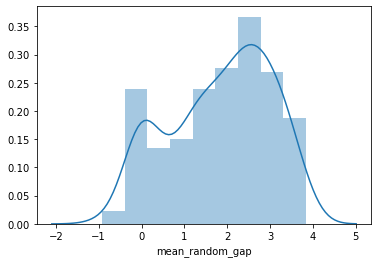

In [113]:
sns.distplot(labelers['mean_random_gap'])
labelers['mean_random_gap'].describe(percentiles=[ .1,.25,.5,.75,.9] )


10 % of the labelers (23) have higher random pairs labels than non random

In [114]:
total_std = df.groupby('annotator')['label'].std()
total_std.name = 'total_std'
labelers = labelers.join(total_std).dropna()

In [115]:
labelers

,size,mean,std,min,max,size_rand,mean_rand,std_rand,min_rand,max_rand,mean_random_gap,std_ratio,total_std
annotator,,,,,,,,,,,,,
A110SC5K5Y3IHS,2,1.500000,0.707107,1,2,3.0,1.333333,0.577350,1.0,2.0,0.166667,1.224745,0.547723
A11YCM5MVQ35YY,8,3.000000,1.309307,1,5,25.0,1.200000,0.645497,1.0,4.0,1.800000,2.028370,1.140674
A123PBQDU71I5O,4,2.750000,0.957427,2,4,3.0,3.333333,0.577350,3.0,4.0,-0.583333,1.658312,0.816497
A12BPQY35PARUO,93,3.537634,1.456314,1,5,114.0,1.035088,0.227718,1.0,3.0,2.502547,6.395264,1.591450
A12NTFM8C8ZFSH,66,3.439394,1.479384,1,5,8.0,1.250000,0.462910,1.0,2.0,2.189394,3.195835,1.561346
...,...,...,...,...,...,...,...,...,...,...,...,...,...
AWLT05JTLRE5C,17,3.529412,1.124591,2,5,3.0,2.333333,1.527525,1.0,4.0,1.196078,0.736218,1.225819
AX3EXSGDXF9ZJ,25,4.840000,0.374166,4,5,4.0,1.000000,0.000000,1.0,1.0,3.840000,inf,1.391388
AX3RDV6XXR1XB,96,3.645833,1.247981,1,5,105.0,1.000000,0.000000,1.0,1.0,2.645833,inf,1.579596


number of labelers with 0 varience: 0, (0.0%)


count    248.000000
mean       1.349573
std        0.387021
min        0.258199
5%         0.593264
10%        0.806974
25%        1.073970
50%        1.431778
75%        1.662378
90%        1.780401
max        2.190890
Name: total_std, dtype: float64

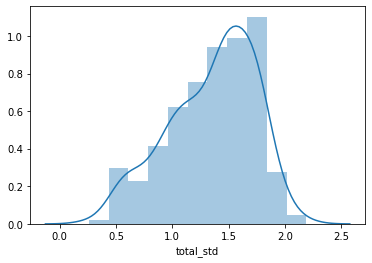

In [116]:
sns.distplot(labelers['total_std'])
print('number of labelers with 0 varience: {}, ({}%)'.format(
    len(labelers[labelers.total_std==0]),
    np.round(
        100*len(labelers[labelers.total_std==0])/len(labelers))
        ))
labelers.total_std.sort_values().describe(percentiles=[.05,.1,.25,.5,.75,.9])

In [24]:
very_suspicious = labelers[(labelers.total_std<1) & (labelers.mean_random_gap <0)]

In [117]:
very_suspicious

,size,mean,std,min,max,size_rand,mean_rand,std_rand,min_rand,max_rand,mean_random_gap,std_ratio,total_std
annotator,,,,,,,,,,,,,
A123PBQDU71I5O,4,2.750000,0.957427,2,4,3.0,3.333333,0.577350,3.0,4.0,-0.583333,1.658312,0.816497
A14KIIR8FGYCHO,202,4.727723,0.683948,1,5,203.0,4.812808,0.471393,2.0,5.0,-0.085085,1.450908,0.587924
A1SBFOZG5J97Z1,7,1.571429,0.786796,1,3,2.0,2.500000,0.707107,2.0,3.0,-0.928571,1.112697,0.833333
A1U9XC376J6ZQ2,161,3.484472,0.829952,1,5,166.0,3.542169,0.775398,2.0,5.0,-0.057697,1.070356,0.802007
A21IZYCFI4AUYU,174,3.000000,0.680020,1,5,174.0,3.011494,0.578902,2.0,4.0,-0.011494,1.174673,0.630604
A2BA1R9MAHHWJH,195,2.728205,0.954087,1,5,199.0,2.964824,0.727365,2.0,4.0,-0.236619,1.311704,0.854360
A2UEGJLWV8VYZA,14,2.642857,1.081818,1,5,52.0,2.730769,0.597885,1.0,4.0,-0.087912,1.809409,0.718228
A32DRYN7M7HIZT,47,3.425532,0.683491,2,5,2.0,3.500000,0.707107,3.0,4.0,-0.074468,0.966602,0.677003
A3746TDKYH8SJ9,265,3.256604,1.008582,1,5,312.0,3.282051,0.947461,1.0,5.0,-0.025448,1.064510,0.975234


In [26]:
labelers[(labelers.total_std>=1) & (labelers.mean_random_gap <0)]

,size,mean,std,min,max,size_rand,mean_rand,std_rand,min_rand,max_rand,mean_random_gap,std_ratio,total_std
annotator,,,,,,,,,,,,,
A168NGIUW93RV5,210,3.071429,1.275324,1,5,133.0,3.172932,1.299833,1.0,5.0,-0.101504,0.981145,1.283943
A1WZJ8VFE5TUO6,34,3.441176,1.956979,1,5,13.0,3.692308,1.887883,1.0,5.0,-0.251131,1.036600,1.920964
A3760PCQD2MPIO,20,1.300000,0.923381,1,4,8.0,1.875000,1.246423,1.0,4.0,-0.575000,0.740824,1.035737
AGGJUBFTYXCCZ,117,3.555556,1.054093,1,5,180.0,3.722222,1.025134,1.0,5.0,-0.166667,1.028248,1.038075


there are 50 labelers with standart deviation labels lower than 1, that constitute 20.16% of the dataset.
19 of those labelers also have a negetive mean difference between non-random and random pairs (82.61% of negative gap).
41 labelers have std and gap lower than 1 (82.0%)


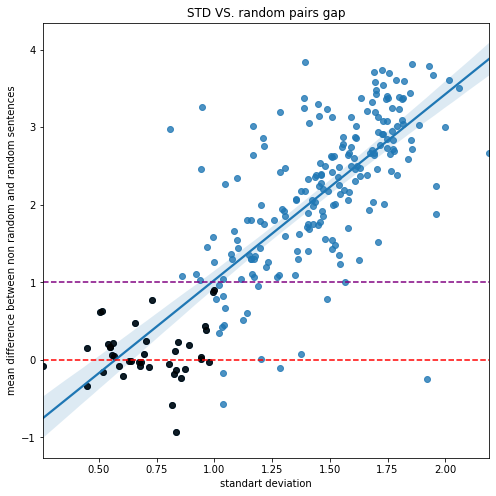

In [118]:
lowstd = labelers[(labelers['total_std']<1)]
neg_gap = labelers[labelers.mean_random_gap<0]
low_gap_std = labelers[(labelers.mean_random_gap<1) & (labelers.total_std<1)]

print(f'there are {len(lowstd)} labelers with standart deviation labels lower than 1, that constitute {np.round(len(lowstd)/len(labelers)*100,2)}% of the dataset.\n19 of those labelers also have a negetive mean difference between non-random and random pairs ({np.round(100*len(very_suspicious)/len(neg_gap),2)}% of negative gap).\n{len(low_gap_std)} labelers have std and gap lower than 1 ({np.round(100*len(low_gap_std)/len(lowstd),2)}%)') 

f,ax = plt.subplots(figsize = (8,8));
sns.regplot('total_std','mean_random_gap',data=labelers);
sns.regplot('total_std','mean_random_gap',data=low_gap_std,color= 'black', ci = None, fit_reg = False);

plt.plot(np.linspace(labelers.total_std.min(),labelers.total_std.max(),50),[0]*50,linestyle = '--', c = 'red')
plt.plot(np.linspace(labelers.total_std.min(),labelers.total_std.max(),50),[1]*50,linestyle = '--', c = 'purple')
plt.xlabel('standart deviation');
plt.ylabel('mean difference between non random and random sentences');
plt.title(label = 'STD VS. random pairs gap');

count    248.000000
mean       0.423387
std        0.995017
min       -1.000000
10%        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
90%        2.000000
max        4.000000
Name: min_diff, dtype: float64

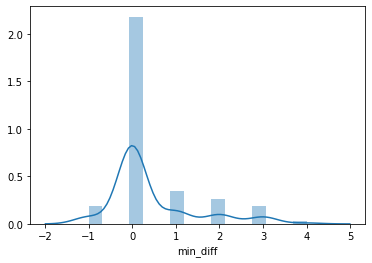

In [119]:
# explore difference between minimum values for random and non-random
labelers['min_diff'] = labelers['min']-labelers['min_rand']
sns.distplot(labelers.min_diff, norm_hist=True)
labelers.min_diff.describe([.1,.25,.5,.75,.9])

In [120]:
labelers[(labelers.min_diff<0) & (labelers.mean_random_gap>0)]

,size,mean,std,min,max,size_rand,mean_rand,std_rand,min_rand,max_rand,mean_random_gap,std_ratio,total_std,min_diff
annotator,,,,,,,,,,,,,,
A2DVT1QU9ZKVQB,32,3.656250,1.405275,1,5,4.0,2.250000,0.500000,2.0,3.0,1.406250,2.810550,1.404076,-1.0
AB77P0ABU54TS,23,4.000000,1.044466,1,5,9.0,3.222222,0.666667,2.0,4.0,0.777778,1.566699,1.007532,-1.0
AE7UECBR4D5E6,211,3.492891,0.972820,1,5,150.0,3.460000,0.902123,2.0,5.0,0.032891,1.078367,0.942948,-1.0


In [121]:
df[df.annotator=='A2DVT1QU9ZKVQB']

,annotator,text1,text2,label,dataset,random,duration,total_seconds,pair_id,reduced_label
2440,A2DVT1QU9ZKVQB,"Yahweh called yet again , `` Samuel ! '' Samue...","And Jehovah called again , Samuel ! And Samuel...",5,bible_human,0,00:00:08,8,pair_813,1
6136,A2DVT1QU9ZKVQB,i doubt he would have so many television s .,i doubt he would have so many television s .,5,gyafc_formal_human,0,00:00:07,7,pair_2045,1
6846,A2DVT1QU9ZKVQB,recently has a pair of companions unable to ha...,i have two friends who could not play battle f...,5,gyafc_formal_human,0,00:00:11,11,pair_2282,1
6869,A2DVT1QU9ZKVQB,i will be your significant other is you come t...,"come to my town , and i ' ll be with you .",5,gyafc_formal_human,0,00:00:10,10,pair_2289,1
7020,A2DVT1QU9ZKVQB,"you are not considered un less you , "" pay it ...",you will not be considered un less you do it b...,4,gyafc_formal_human,0,00:00:08,8,pair_2340,1
7094,A2DVT1QU9ZKVQB,did you go on a date ?,"without lust as in you only go on dates , corr...",4,gyafc_formal_human,0,00:00:12,12,pair_2364,1
7493,A2DVT1QU9ZKVQB,because some women send men tiny messages wit...,because some women send subtle messages to men...,5,gyafc_formal_human,0,00:01:19,79,pair_2497,1
7852,A2DVT1QU9ZKVQB,when she slow s down the love making .,has she halte d sleeping with you ?,3,gyafc_formal_human,0,00:00:23,23,pair_2617,0
7882,A2DVT1QU9ZKVQB,"if you do , then i would say that it is real a...","if you truly do , i would say that is was a re...",5,gyafc_formal_human,0,00:00:10,10,pair_2627,1
8174,A2DVT1QU9ZKVQB,a trip to an amusement park in cluding roller ...,a trip to a amusement park such as a roller co...,4,gyafc_formal_human,0,00:00:15,15,pair_2724,1


it seems that adding the difference between minimum random and non-random doesn' add much nformation.<br>
the only new suspicious labeler added, looks like a legit one (albeit a bit harsh negation effect on similarity)

In [122]:
legit = labelers[(labelers.mean_random_gap>0) & (labelers.total_std>1)]
legit_df = df[df.annotator.apply(lambda x: x in legit.index)]

In [123]:
len(legit_df)/len(df), len(legit)/df.annotator.nunique(), len(legit)/len(labelers)

(0.6125429113080904, 0.5574712643678161, 0.782258064516129)

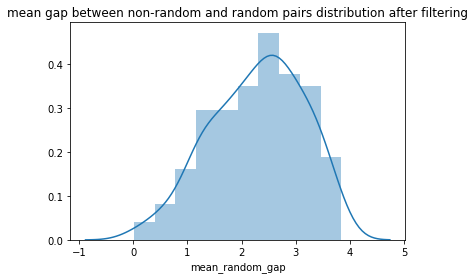

In [124]:
sns.distplot(legit['mean_random_gap']);
plt.title('mean gap between non-random and random pairs distribution after filtering');


# Conclusions:
- it appears that mean gap between non-random and random sentencs pair is a good indicator for bad labelers
- low standard deviation also is a fair indicator for lazy labaling
- after removing labelers which doesn't have both random and nn random sentences, lower std than 1 and lower mean gap than 0, we have:<br>
    - 194 unique labelers (55.7 % of original dataset and 78.2% of dataset after filtering labeler that don't have both random and non-random labels)
    - 23910 labeled pairs (61.2 % of original data)
- if we use a stricter criterion (std>1 & mean gap>1):
    - 180 labelers (51.% of labelers, 72.5% after initial filtering)
    - 20529 labeled pairs (52.6% of data)

# Next step:
Re-running some of Shaul's analysis on the filtered dataset:
- duration correlation with labeles and length
- amount of disagreement
    
    

In [125]:
from nltk.tokenize import word_tokenize

def tok_text(text):
    tokens = word_tokenize(text)
    # remove all tokens that are not alphabetic
    return [word for word in tokens if word.isalpha()]

In [126]:
df['len_sent'] = df.text1.apply(lambda x: len(tok_text(x))) + df.text2.apply(lambda x: len(tok_text(x)))
legit_df = df[df.annotator.apply(lambda x: x in legit.index)]

In [127]:
legit_df['len_sent'].corr(legit_df['total_seconds']), legit_df['len_sent'].corr(legit_df['label'])

(0.031860247110562935, 0.01265315826314298)

It appears that the correlation between duraion and length has grown and the correlation between length and labels has dropped, indicating better labeling.<br>
BUT, it is still VERY close to 0

In [128]:
df_random_grouped = legit_df.groupby("random")
for name, group in df_random_grouped:
    print(f"{name} has a correlation of {group['len_sent'].corr(group['total_seconds'])}")

0 has a correlation of 0.046697061147150984
1 has a correlation of 0.016227291917054663


In [129]:
df_dataset_grouped = legit_df.groupby("dataset")
for name, group in df_dataset_grouped:
    print(f"{name} has a correlation of {group['len_sent'].corr(group['total_seconds']):.3f}")

bible_human has a correlation of 0.061
bible_random_human has a correlation of 0.001
gyafc_formal_human has a correlation of -0.016
gyafc_formal_random_human has a correlation of 0.021
gyafc_informal_human has a correlation of 0.023
gyafc_informal_random_human has a correlation of 0.013
gyafc_rewrites_human has a correlation of 0.027
gyafc_rewrites_random_human has a correlation of 0.003
paralex_human has a correlation of -0.010
paralex_random_human has a correlation of 0.020
paraphrase_human has a correlation of 0.030
paraphrase_random_human has a correlation of -0.006
yelp_human has a correlation of 0.054
yelp_random_human has a correlation of -0.019


Shaul has already put it well:<br>
**There is no obvious distinctions between the different datasets, whether regular pairs or random pairs, that show relation between length and duration.**

In [144]:
legit_df['pair_id'].value_counts().value_counts()

2    5791
1    3742
3    2862
Name: pair_id, dtype: int64

In [185]:
652/2826

0.23071479122434538

*Problem*:
after filtering annotator, we don't have enough data to explore sentence pairs disagreement, since only 2862 pairs have 3 labels

In [174]:
p3 = legit_df['pair_id'].value_counts()[(legit_df['pair_id'].value_counts()==3)].index
p3 = legit_df[legit_df['pair_id'].apply(lambda x: x in p3)]

In [183]:
sum(p3.groupby("pair_id")["reduced_label"].nunique() == 3),sum(p3.groupby("pair_id")["label"].nunique() == 3)

(198, 652)

out of 2826 pairs, only in 652 (23%) pairs there are 3 unique labels, and only in 198 (7%) pairs there are 3 unique reduced labels.
getting rid of bad labelers increases consensus

In [188]:
df_uniquelabels = p3.groupby("pair_id")["reduced_label"].nunique()
pairs_twoagree = list(df_uniquelabels[(p3.groupby("pair_id")["reduced_label"].nunique() == 2).values].index)
df_twoagree = p3[p3["pair_id"].isin(pairs_twoagree)]

In [190]:
df_id_reducedlabel = df_twoagree.groupby("pair_id")['reduced_label'].median()
df_twoagree['generally_accepted_label']  = df_id_reducedlabel.values.repeat(3)
df_twoagree[df_twoagree.reduced_label != df_twoagree.generally_accepted_label].groupby('annotator').size()

annotator
A11YCM5MVQ35YY     1
A12BPQY35PARUO    10
A12NTFM8C8ZFSH     7
A139DFNZS0I9RB    18
A14CLZWROI8UCS    48
                  ..
AW6QLOMTOO770      4
AWLT05JTLRE5C      2
AX3EXSGDXF9ZJ      4
AX3RDV6XXR1XB     17
AZYMR3317SUFN      4
Length: 184, dtype: int64